<a href="https://colab.research.google.com/github/marcusnk237/noisy_ecg_to_ecg_ppgs/blob/main/10_k_fold_cross_validation_Noisy_ECG_to_ECG_Red_PPG_and_IR_PPG(PTT%2BBIDMC)V3_SNR_Min_Max_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

The goal of this projet is to generate from noisy ECG signals:
- Clean ECG signal
- Clean Red Light PPG signal
- Clean Infrared Light PPG Signal

The clean PPG signals will be use to compute SpO2, and the clean ECG will be use for Heartrate computation

The model code is inspired by <a href=" https://github.com/pritamqu/ppg2ecg-cardiogan" > Cardiogan</a>



# Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load libraries

In [ ]:
!pip install tensorflow_addons
!pip install biosppy
!pip install matplotx
import cv2,gc,os,random,sklearn,itertools,scipy,logging,biosppy
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from sklearn.utils import resample,shuffle
import matplotlib.font_manager as font_manager
from scipy.interpolate import CubicSpline
from random import choice,randint
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import signal
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from biosppy.signals import tools as tools



from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras import Model,Sequential,regularizers
from tensorflow.keras.layers import MaxPool1D , Dense, Conv2D , Conv2DTranspose, Input , MaxPooling1D ,  Flatten , add , Dropout , BatchNormalization , LayerNormalization
from tensorflow.keras.activations import relu , tanh , sigmoid , softmax
from tensorflow_addons.layers import InstanceNormalization
from scipy import stats
from tensorflow import random_normal_initializer,squeeze

from collections import Counter
# Generate and plot a synthetic imbalanced classification dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

#### Import libraries

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 1.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)

# Voltage conversion
For real data testing purpose

In [ ]:
def voltage(x):
  return ((3.3*1000)/(550*1023))*x

# SpO2 Formula

In [ ]:
def  getSpO2(R,I):

  ratio_of_red=np.max(R) - np.min(R)
  ratio_of_ir=(np.max(I) - np.min(I))

  ratio_of_ratios = ratio_of_red/ratio_of_ir

  spo2=min(11.78*(ratio_of_ratios*ratio_of_ratios*ratio_of_ratios) - 55.92*(ratio_of_ratios*ratio_of_ratios) + 28.84*ratio_of_ratios + 97.12,100)

  return spo2

In [ ]:
def  computeSpO2(R,I):

  ratio_of_red=(np.max(R) - np.min(R))/np.min(R)
  ratio_of_ir=(np.max(I) - np.min(I))/np.min(I)

  ratio_of_ratios = ratio_of_red/ratio_of_ir

  spo2=min(11.78*(ratio_of_ratios*ratio_of_ratios*ratio_of_ratios) - 55.92*(ratio_of_ratios*ratio_of_ratios) + 28.84*ratio_of_ratios + 97.12,100)

  return spo2

# Data loading
We save the augmented dataset to npy files.
The datas consists of :
- The Noisy ECG signals (input)
- Clean ECG , PPG IR and PPG Red signals (outputs)

The min max method used was mean normalization.
Dimension expansion was already performs


In [ ]:
noisy_X_df=pd.read_csv("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/noisy_ecg.csv")
X_ecg_df=pd.read_csv("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ecg.csv")
X_red_df=pd.read_csv("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/red.csv")
X_ir_df=pd.read_csv("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ir.csv")

noisy_X_df=noisy_X_df.astype('float32')
X_ecg_df=X_ecg_df.astype('float32')
X_red_df=X_red_df.astype('float32')
X_ir_df=X_ir_df.astype('float32')

In [ ]:
noisy_X=noisy_X_df.iloc[:,1:].values
X_ecg=X_ecg_df.iloc[:,1:].values
X_red=X_red_df.iloc[:,1:].values
X_ir=X_ir_df.iloc[:,1:].values

In [ ]:
######### Time length
F_s=128
N=4
t_p = np.linspace(0,N, N*F_s)

# Signal generation with GAN

## Layers
Layers used for the model:
- Dense Layer
- Conv1D Layer
- DeConv1D Layer
- Activations functions (sigmoid, relu, tanh, leaky_relu,softmax)
- Dropout
- Normalization ( layer normalization, batch normalization)
- Attention block (adopted from https://github.com/lixiaolei1982/Keras-Implementation-of-U-Net-R2U-Net-Attention-U-Net-Attention-R2U-Net.-/blob/master/network.py)


In [ ]:
weights_initializer = random_normal_initializer(mean=0.0, stddev=0.02, seed=None)

def Dense(units, activation=None):
    op = Dense(units=units, activation=activation, use_bias=True, kernel_initializer=weights_initializer,
                               bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                               kernel_constraint=None, bias_constraint=None)

    return op

def Conv1D(filters, kernel_size, strides=1, padding='valid', activation=None, use_bias=True):
    op = Conv2D(filters=filters, kernel_size=(1, kernel_size), strides=(1, strides), padding=padding, data_format='channels_last',
                                dilation_rate=1, activation=None, use_bias=use_bias,
                                kernel_initializer=weights_initializer, bias_initializer='zeros',
                                kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                                kernel_constraint=None, bias_constraint=None)

    return op

Conv2D = Conv2D

def DeConv1D(filters, kernel_size, strides=1, padding='valid', use_bias=True):
    op = Conv2DTranspose(filters= filters, kernel_size=(1, kernel_size), strides=(1, strides), padding=padding,
                                         output_padding=None, data_format=None, dilation_rate=(1, 1), activation=None, use_bias=use_bias,
                                         kernel_initializer=weights_initializer, bias_initializer='zeros', kernel_regularizer=None,
                                         bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

    return op

def BatchNormalization(trainable=True, virtual_batch_size=None):
    op = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                                            beta_initializer='zeros', gamma_initializer='ones',
                                            moving_mean_initializer='zeros', moving_variance_initializer='ones',
                                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
                                            gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
                                            fused=None, trainable=trainable, virtual_batch_size=virtual_batch_size, adjustment=None, name=None)

    return op

def Activation(x, activation):
    if activation == 'relu':
        return relu(x, alpha=0.0, max_value=None, threshold=0)
    elif activation == 'leaky_relu':
        return relu(x, alpha=0.3, max_value=None, threshold=0)
    elif activation == 'sigmoid':
        return sigmoid(x)
    elif activation == 'softmax':
        return softmax(x, axis=-1)
    elif activation == 'tanh':
        return tanh(x)
    else:
        raise ValueError('please check the name of the activation')


def Dropout(rate):
    op = Dropout(rate=rate, noise_shape=None, seed=None)
    return op

def flatten():
    op = Flatten(data_format=None)
    return op

def normalization(name):

    if name =='none':
        return lambda: lambda x: x
    elif name == 'batch_norm':
        return keras.layers.BatchNormalization()
    elif name == 'instance_norm':
        return InstanceNormalization()
    elif name == 'layer_norm':
        return LayerNormalization()

def attention_block_1d(curr_layer, conn_layer):
    inter_channel = curr_layer.get_shape().as_list()[3]
    theta_x = Conv1D(inter_channel, 1, 1)(conn_layer)
    phi_g = Conv1D(inter_channel, 1, 1)(curr_layer)
    f = Activation(keras.layers.add([theta_x, phi_g]), 'leaky_relu')
    psi_f = Conv1D(1, 1, 1)(f)
    rate = Activation(psi_f, 'sigmoid')
    att_x = keras.layers.multiply([conn_layer, rate])
    return att_x

## Model

In [ ]:
def generator_attention(input_shape=512,
                      filter_size=[64,64,32,32,32,32,64,64],
                      kernel_size=[16,16,16,16,16,16,16,16],
                      n_downsample=8,
                      norm='layer_norm',
                      skip_connection=True):

    """
    input_shape = 128*1

    """

    ########################  downsampling function ########################
    def _downsample(ip, filter_size, kernel_size, norm, stride_size=2):

        ip = Conv1D(filters=filter_size, kernel_size=kernel_size, strides=stride_size, padding='same', use_bias=False)(ip)
        if norm != 'none':
            ip = normalization(norm)(ip)
        ip = Activation(ip, activation='relu')
        return ip
    ######################## Upsampling function ########################
    def _upsample(ip, filter_size, kernel_size, norm, stride_size=2, drop_rate = 0.5, apply_dropout=False):

        ip = DeConv1D(filters=filter_size, kernel_size=kernel_size, strides=stride_size, padding='same', use_bias=False)(ip)
        if norm != 'none':
            ip = normalization(norm)(ip)
        if apply_dropout:
            ip = Dropout(rate=drop_rate)
        ip = Activation(ip, activation='relu')

        return ip


    ## input
    h = inputs = keras.Input(shape=input_shape) # None, 128
    h = tf.expand_dims(h, axis=1) # None, 1, 128
    h = tf.expand_dims(h, axis=3) # None, 1, 128, 1
    ######################## downsampling ########################
    connections = []
    for k in range(n_downsample):
        if k==0:
            h =  _downsample(h, filter_size[k], kernel_size[k], norm)
        else:
            h =  _downsample(h, filter_size[k], kernel_size[k], norm)

        connections.append(h)

    ######################## upsampling ########################`
    h = _upsample(h, filter_size[k], kernel_size[k], norm, stride_size=1)
    if skip_connection:
        _h = attention_block_1d(curr_layer= h, conn_layer= connections[n_downsample-1])
        h  = keras.layers.add([h, _h])

    for l in range(1, n_downsample):
        h  = _upsample(h, filter_size[k-l], kernel_size[k-l], norm)
        if skip_connection:
            _h = attention_block_1d(curr_layer= h, conn_layer= connections[k-l])
            h  = keras.layers.add([h, _h])

    ## outputs
    h_ecg = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ecg = Activation(h_ecg, activation='tanh')
    h_ecg = tf.squeeze(h_ecg, axis=1)
    h_ecg = tf.squeeze(h_ecg, axis=2)

    h_ac_red = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ac_red = Activation(h_ac_red ,activation='tanh')
    h_ac_red = tf.squeeze(h_ac_red, axis=1)
    h_ac_red = tf.squeeze(h_ac_red, axis=2)

    h_ac_ir = DeConv1D(filters=1, kernel_size=kernel_size[k-l], strides=2, padding='same')(h)
    h_ac_ir = Activation(h_ac_ir, activation='tanh')
    h_ac_ir = tf.squeeze(h_ac_ir, axis=1)
    h_ac_ir = tf.squeeze(h_ac_ir, axis=2)

    return keras.Model(inputs=inputs, outputs=[h_ecg,h_ac_red,h_ac_ir] , name = 'noisy_to_ecg_red_ir')

### Metrics

In [ ]:
def SNR(signal, noise):

    powS = np.mean(np.square(signal), axis = 0)
    powN = np.mean(np.square(noise), axis = 0)
    print(powS)
    print(powN)
    return 10*np.log10((powS-powN)/powN)

In [ ]:
from keras import backend as K
def PRD(y_true, y_pred):
    return K.sqrt((K.mean(K.square(y_pred - y_true))/K.mean(K.square(y_true))))


In [ ]:
class CorrelationMetric(keras.metrics.Metric):
    def __init__(self, name="correlation", **kwargs):
        super(CorrelationMetric, self).__init__(name=name, **kwargs)
        self.correlation = self.add_weight(name="correlation", initializer="zeros")
        self.n = self.add_weight(name="n", initializer="zeros")
        self.x = self.add_weight(name="x", initializer="zeros")
        self.x_squared = self.add_weight(name="x_squared", initializer="zeros")
        self.y = self.add_weight(name="y", initializer="zeros")
        self.y_squared = self.add_weight(name="y_squared", initializer="zeros")
        self.xy = self.add_weight(name="xy", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.n.assign_add(tf.reduce_sum(tf.cast((y_pred == y_true), "float32")))
        self.n.assign_add(tf.reduce_sum(tf.cast((y_pred != y_true), "float32")))
        self.xy.assign_add(tf.reduce_sum(tf.multiply(y_pred, y_true)))
        self.x.assign_add(tf.reduce_sum(y_pred))
        self.y.assign_add(tf.reduce_sum(y_true))
        self.x_squared.assign_add(tf.reduce_sum(tf.math.square(y_pred)))
        self.y_squared.assign_add(tf.reduce_sum(tf.math.square(y_true)))

    def result(self):
        return (self.n * self.xy - self.x * self.y)/tf.math.sqrt((self.n * self.x_squared - tf.math.square(self.x)) * (self.n * self.y_squared - tf.math.square(self.y)))

    def reset_state(self):
        self.n.assign(0.0)
        self.x.assign(0.0)
        self.x_squared.assign(0.0)
        self.y.assign(0.0)
        self.y_squared.assign(0.0)
        self.xy.assign(0.0)
        self.correlation.assign(0.0)

In [ ]:
# calculate frechet inception distance

def calculate_fid(y_true, y_pred):
  return K.mean(y_true * y_pred)

In [ ]:
"""
def SNRsystem(inputSig, outputSig):
    noise = outputSig-inputSig

    powS = np.mean(np.square(outputSig), axis = 0)
    powN = np.mean(np.square(noise), axis = 0)
    return 10*np.log10((powS-powN)/powN)
"""

'\ndef SNRsystem(inputSig, outputSig):\n    noise = outputSig-inputSig\n\n    powS = np.mean(np.square(outputSig), axis = 0)\n    powN = np.mean(np.square(noise), axis = 0)\n    return 10*np.log10((powS-powN)/powN)\n'

In [ ]:
import numpy as np
import scipy.io as sio
import math
def calculateSNR(testy, predictions):
    try:
        SNR_after =  10 * np.log10(np.mean(np.square(predictions), axis = 0)  / np.mean(np.square(predictions - testy), axis = 0))
    except:
        SNR_after =-3
    if math.isinf(SNR_after):
      SNR_after=0
    return SNR_after



In [ ]:
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    snr=10*np.log10(abs(np.where(sd == 0, 0, m/sd)))
    if (math.isnan(snr)):
      snr=0
    return snr

## Training

In [ ]:
def scale_fn(x):
  return tf.pow(0.95,x)

In [ ]:
dumb=np.array([0 for i in range(len(noisy_X))])

In [ ]:
"""
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
shufflesplit = StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2)
Tr,Tst=[],[]
for i, (train_idx, test_idx) in enumerate(shufflesplit.split(noisy_X, dumb)):
  Tr.append(train_idx)
  Tst.append(test_idx)
"""

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
shufflesplit = StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2)
Tr,Tst=[],[]
for i, (train_idx, test_idx) in enumerate(shufflesplit.split(noisy_X, dumb)):
  Tr.append(train_idx)
  Tst.append(test_idx)

In [ ]:
for i, (train_idx, test_idx) in enumerate(shufflesplit.split(noisy_X, dumb)):

  print("*"*100+"\nIteration {}\n".format(i+1))
  print("*"*100)
  N=noisy_X[train_idx].shape[0]
  batch_size = 16* tpu_strategy.num_replicas_in_sync
  iterations = N/batch_size
  step_size= 2 * iterations
  noisy_X_test,noisy_X_val,X_ecg_test,X_ecg_val, X_red_test, X_red_val, X_ir_test, X_ir_val = train_test_split (noisy_X[test_idx], X_ecg[test_idx],X_red[test_idx],X_ir[test_idx],test_size=0.5,random_state=42,shuffle=True)
  lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=scale_fn)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  with tpu_strategy.scope():
    gan = generator_attention()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) # Early stopping parameters
    save_best_weights = ModelCheckpoint(filepath="/content/drive/MyDrive/10_fold_validation_ecg_ppg/new_autoencoder_ecg_red_ir_{}.hdf5".format(i+1), verbose=2, save_best_only=True , restore_best_weights=True) # Model checkpoint parameters

    gan.compile(optimizer=optimizer,
              loss = {
                  gan.get_layer(index = -3).name : 'mse',
                  gan.get_layer(index = -2).name : 'mse' ,
                  gan.get_layer(index = -1).name : 'mse'
                  },
              metrics = {
                  gan.get_layer(index = -3).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid],
                  gan.get_layer(index = -2).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid],
                  gan.get_layer(index = -1).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid]
                 }
        )
    history = gan.fit( noisy_X[train_idx], [X_ecg[train_idx],X_red[train_idx],X_ir[train_idx]] , validation_data=(noisy_X_val, [X_ecg_val,X_red_val,X_ir_val]), batch_size=batch_size, epochs=100, callbacks=[save_best_weights,early_stopping])
    model_evaluation = gan.evaluate(noisy_X_test, [X_ecg_test,X_red_test,X_ir_test])
    print('*'*50+'\n'+'MODEL {} EVALUATION'.format(i+1)+'\n'+'*'*50)
    print('*'*25+'Losses'+'*'*25)
    print(model_evaluation)
    print('*'*60)
    print('-'*100)

    np.save("/content/drive/MyDrive/10_fold_validation_ecg_ppg/new autoencoder_ecg_red_ir_{}.npy".format(i+1),history.history)

****************************************************************************************************
Iteration 1

****************************************************************************************************
Epoch 1/100
2364/2364 [==============================] - ETA: 0s - loss: 0.0595 - tf.compat.v1.squeeze_1_loss: 0.0125 - tf.compat.v1.squeeze_3_loss: 0.0142 - tf.compat.v1.squeeze_5_loss: 0.0328 - tf.compat.v1.squeeze_1_mae: 0.0708 - tf.compat.v1.squeeze_1_root_mean_squared_error: 0.1117 - tf.compat.v1.squeeze_1_PRD: 0.4530 - tf.compat.v1.squeeze_1_correlation: 0.8261 - tf.compat.v1.squeeze_1_calculate_fid: 0.0396 - tf.compat.v1.squeeze_3_mae: 0.0807 - tf.compat.v1.squeeze_3_root_mean_squared_error: 0.1190 - tf.compat.v1.squeeze_3_PRD: 0.6015 - tf.compat.v1.squeeze_3_correlation: 0.3702 - tf.compat.v1.squeeze_3_calculate_fid: 0.0226 - tf.compat.v1.squeeze_5_mae: 0.1333 - tf.compat.v1.squeeze_5_root_mean_squared_error: 0.1812 - tf.compat.v1.squeeze_5_PRD: 0.5017 - tf.compat.v1

In [ ]:
for i, (train_idx, test_idx) in enumerate(shufflesplit.split(noisy_X, dumb)):

  print("*"*100+"\nIteration {}\n".format(i+8))
  print("*"*100)
  N=noisy_X[train_idx].shape[0]
  batch_size = 16* tpu_strategy.num_replicas_in_sync
  iterations = N/batch_size
  step_size= 2 * iterations
  noisy_X_test,noisy_X_val,X_ecg_test,X_ecg_val, X_red_test, X_red_val, X_ir_test, X_ir_val = train_test_split (noisy_X[test_idx], X_ecg[test_idx],X_red[test_idx],X_ir[test_idx],test_size=0.5,random_state=42,shuffle=True)
  lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=scale_fn)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  with tpu_strategy.scope():
    gan = generator_attention()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) # Early stopping parameters
    save_best_weights = ModelCheckpoint(filepath="/content/drive/MyDrive/10_fold_validation_ecg_ppg/new_autoencoder_ecg_red_ir_{}.hdf5".format(i+8), verbose=2, save_best_only=True , restore_best_weights=True) # Model checkpoint parameters

    gan.compile(optimizer=optimizer,
              loss = {
                  gan.get_layer(index = -3).name : 'mse',
                  gan.get_layer(index = -2).name : 'mse' ,
                  gan.get_layer(index = -1).name : 'mse'
                  },
              metrics = {
                  gan.get_layer(index = -3).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid],
                  gan.get_layer(index = -2).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid],
                  gan.get_layer(index = -1).name: ['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid]
                 }
        )
    history = gan.fit( noisy_X[train_idx], [X_ecg[train_idx],X_red[train_idx],X_ir[train_idx]] , validation_data=(noisy_X_val, [X_ecg_val,X_red_val,X_ir_val]), batch_size=batch_size, epochs=100, callbacks=[save_best_weights,early_stopping])
    model_evaluation = gan.evaluate(noisy_X_test, [X_ecg_test,X_red_test,X_ir_test])
    print('*'*50+'\n'+'MODEL {} EVALUATION'.format(i+8)+'\n'+'*'*50)
    print('*'*25+'Losses'+'*'*25)
    print(model_evaluation)
    print('*'*60)
    print('-'*100)

    np.save("/content/drive/MyDrive/10_fold_validation_ecg_ppg/new autoencoder_ecg_red_ir_{}.npy".format(i+8),history.history)

****************************************************************************************************
Iteration 8

****************************************************************************************************
Epoch 1/100
2364/2364 [==============================] - ETA: 0s - loss: 0.0617 - tf.compat.v1.squeeze_1_loss: 0.0144 - tf.compat.v1.squeeze_3_loss: 0.0121 - tf.compat.v1.squeeze_5_loss: 0.0352 - tf.compat.v1.squeeze_1_mae: 0.0747 - tf.compat.v1.squeeze_1_root_mean_squared_error: 0.1198 - tf.compat.v1.squeeze_1_PRD: 0.4728 - tf.compat.v1.squeeze_1_correlation: 0.7991 - tf.compat.v1.squeeze_1_calculate_fid: 0.0386 - tf.compat.v1.squeeze_3_mae: 0.0771 - tf.compat.v1.squeeze_3_root_mean_squared_error: 0.1099 - tf.compat.v1.squeeze_3_PRD: 0.5795 - tf.compat.v1.squeeze_3_correlation: 0.4482 - tf.compat.v1.squeeze_3_calculate_fid: 0.0238 - tf.compat.v1.squeeze_5_mae: 0.1374 - tf.compat.v1.squeeze_5_root_mean_squared_error: 0.1877 - tf.compat.v1.squeeze_5_PRD: 0.5148 - tf.compat.v1

# SNR Evaluation

In [ ]:
lr_schedule = CyclicalLearningRate(1e-6, 1e-4, step_size=20, scale_fn=scale_fn)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
noisy_X_test=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/noisy_X_test_32.npy")
X_test_ecg=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/ECG_X_test_32.npy")
X_test_red=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/RED_X_test_32.npy")
X_test_ir=np.load("/content/drive/MyDrive/ECG_TO_PPG/min max normalization/IR_X_test_32.npy")

In [ ]:
for i in range(10):

  model= tf.keras.models.load_model("/content/drive/MyDrive/10_fold_validation_ecg_ppg/new_autoencoder_ecg_red_ir_{}.hdf5".format(i+1), compile=False)
  model.compile(optimizer=optimizer, loss='mse',metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid])

  ecgs,reds,irs =model(noisy_X_test)
  reds_predict=reds.numpy()
  red_inputs = X_test_red.reshape(X_test_red.shape[0], X_test_red.shape[1])

  irs_predict=irs.numpy()
  ir_inputs = X_test_ir.reshape(X_test_ir.shape[0], X_test_ir.shape[1])

  ecgs_predict=ecgs.numpy()
  noises = noisy_X_test.reshape(noisy_X_test.shape[0], noisy_X_test.shape[1])
  inputs = X_test_ecg.reshape(X_test_ecg.shape[0], X_test_ecg.shape[1])
  SNR_befores_ecg, SNR_afters_ecg,  SNR_after_reds , SNR_after_irs, SNR_before_reds , SNR_before_irs = [],[],[],[],[],[]
  for k in range(len(ecgs_predict)):
      try:
          SNR_befores_ecg.append(signaltonoise_dB(inputs[k]))
          SNR_afters_ecg.append(calculateSNR(inputs[k],ecgs_predict[k]))

          SNR_before_reds.append(signaltonoise_dB(red_inputs[k]))
          SNR_after_reds.append(calculateSNR(red_inputs[k],reds_predict[k]))

          SNR_before_irs.append(signaltonoise_dB(ir_inputs[k]))
          SNR_after_irs.append(calculateSNR(ir_inputs[k],irs_predict[k]))
      except:
          print(k)

  SNR_afters_ecg=np.nan_to_num(SNR_afters_ecg)
  SNR_after_reds=np.nan_to_num(SNR_after_reds)
  SNR_after_irs=np.nan_to_num(SNR_after_irs)

  SNR_befores_ecg=np.nan_to_num(SNR_befores_ecg)
  SNR_before_reds=np.nan_to_num(SNR_before_reds)
  SNR_before_irs=np.nan_to_num(SNR_before_irs)


  ecg_aft = np.mean(SNR_afters_ecg)
  red_aft = np.mean(SNR_after_reds)
  ir_aft  = np.mean(SNR_after_irs)

  ecg_bef = np.mean(SNR_befores_ecg)
  red_bef = np.mean(SNR_before_reds)
  ir_bef  = np.mean(SNR_before_irs)

  print('*'*50+' Iteration {}'.format(i+1)+'*'*50+'\n')

  print('SNR  ECG (dB) IN:{}'.format(ecg_bef))
  print('SNR  PPG IR (dB) IN :{}'.format(red_bef))
  print('SNR  PPG RED (dB) IN :{}'.format(ir_bef))

  print('SNR  ECG (dB) OUT:{}'.format(ecg_aft))
  print('SNR  PPG IR (dB) OUT :{}'.format(red_aft))
  print('SNR  PPG RED (dB) OUT :{}'.format(ir_aft))

  print('SNR  improvement ECG (dB) :{}'.format(ecg_aft-ecg_bef))
  print('SNR  improvement PPG IR (dB) :{}'.format(ir_aft-ir_bef))
  print('SNR  improvement PPG RED (dB) :{}'.format(red_aft-red_bef))
  print('*'*115+'\n')

************************************************** Iteration 1**************************************************

SNR  ECG (dB) IN:4.243050247159664
SNR  PPG IR (dB) IN :2.6634505347718833
SNR  PPG RED (dB) IN :2.6309333806917476
SNR  ECG (dB) OUT:21.94259271553167
SNR  PPG IR (dB) OUT :17.000023892483195
SNR  PPG RED (dB) OUT :19.155938586276385
SNR  improvement ECG (dB) :17.69954246837201
SNR  improvement PPG IR (dB) :16.525005205584637
SNR  improvement PPG RED (dB) :14.336573357711313
*******************************************************************************************************************

************************************************** Iteration 2**************************************************

SNR  ECG (dB) IN:4.243050247159664
SNR  PPG IR (dB) IN :2.6634505347718833
SNR  PPG RED (dB) IN :2.6309333806917476
SNR  ECG (dB) OUT:22.001294989271965
SNR  PPG IR (dB) OUT :16.79805972267162
SNR  PPG RED (dB) OUT :18.832813803125184
SNR  improvement ECG (dB) :17.75824474211

In [ ]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.9 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk
from collections import Counter
for i in range(10):

  model= tf.keras.models.load_model("/content/drive/MyDrive/10_fold_validation_ecg_ppg/new_autoencoder_ecg_red_ir_{}.hdf5".format(i+1), compile=False)
  model.compile(optimizer=optimizer, loss='mse',metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),PRD,CorrelationMetric(),calculate_fid])

  ecgs,reds,irs =model(noisy_X_test)
  reds_predict=reds.numpy()
  red_inputs = X_test_red.reshape(X_test_red.shape[0], X_test_red.shape[1])

  irs_predict=irs.numpy()
  ir_inputs = X_test_ir.reshape(X_test_ir.shape[0], X_test_ir.shape[1])

  ecgs_predict=ecgs.numpy()
  noises = noisy_X_test.reshape(noisy_X_test.shape[0], noisy_X_test.shape[1])
  inputs = X_test_ecg.reshape(X_test_ecg.shape[0], X_test_ecg.shape[1])
  ecg_quality,red_quality,ir_quality = [],[],[]
  for k in range(len(ecgs_predict)):
      try:
          ecg_quality.append(nk.ecg_quality(ecgs_predict[k],
                         sampling_rate=F_s,
                         method="zhao2018",
                         approach="fuzzy"
                         ))
          red_quality.append(nk.ecg_quality(reds_predict[k],
                         sampling_rate=F_s,
                         method="zhao2018",
                         approach="fuzzy"
                         ))
          ir_quality.append(nk.ecg_quality(irs_predict[k],
                         sampling_rate=F_s,
                         method="zhao2018",
                         approach="fuzzy"
                         ))
      except:
          print(k)

  print('*'*50+' Iteration {}'.format(i+1)+'*'*50+'\n')

  print('ECG quality:\n')
  print(Counter(ecg_quality))
  print('PPG Red quality:\n')
  print(Counter(red_quality))
  print('PPG Ir quality:\n')
  print(Counter(ir_quality))

  print('*'*115+'\n')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


************************************************** Iteration 1**************************************************

ECG quality:

Counter({'Barely acceptable': 17189})
PPG Red quality:

Counter({'Barely acceptable': 17189})
PPG Ir quality:

Counter({'Barely acceptable': 17189})
*******************************************************************************************************************



/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


************************************************** Iteration 2**************************************************

ECG quality:

Counter({'Barely acceptable': 17189})
PPG Red quality:

Counter({'Barely acceptable': 17189})
PPG Ir quality:

Counter({'Barely acceptable': 17189})
*******************************************************************************************************************



/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


233
322


# Comparison with data recorded with oxymeter and ECG sensor

## Load datas

In [ ]:
ecg_arduinos,ppg_red_arduino,ppg_ir_arduino=[],[],[]
f = open('/content/PPGECG.txt','r')

for row in f:
    rows = row.split('\t')
    try:
      ecg_arduinos.append(float(rows[0]))
    except:
      pass
    try:
      ppg_red_arduino.append(float(rows[1]))
    except:
      pass
    try:
       r = rows[2].split('\n')
       ppg_ir_arduino.append(float(r[0]))
    except:
      pass

## Min Max normalization

In [ ]:
q=500
ecg_arduino = (ecg_arduinos[q:q+512]-np.min(ecg_arduinos[q:q+512]))/(np.max(ecg_arduinos[q:q+512])-np.min(ecg_arduinos[q:q+512]))
red_arduino = (ppg_red_arduino[q:q+512]-np.min(ppg_red_arduino[q:q+512]))/(np.max(ppg_ir_arduino[q:q+512])-np.min(ppg_ir_arduino[q:q+512]))
ir_arduino = (ppg_ir_arduino[q:q+512]-np.min(ppg_ir_arduino[q:q+512]))/(np.max(ppg_ir_arduino[q:q+512])-np.min(ppg_ir_arduino[q:q+512]))
ecg_ppg_signals= gan(np.array([ecg_arduino]))

## Plot results

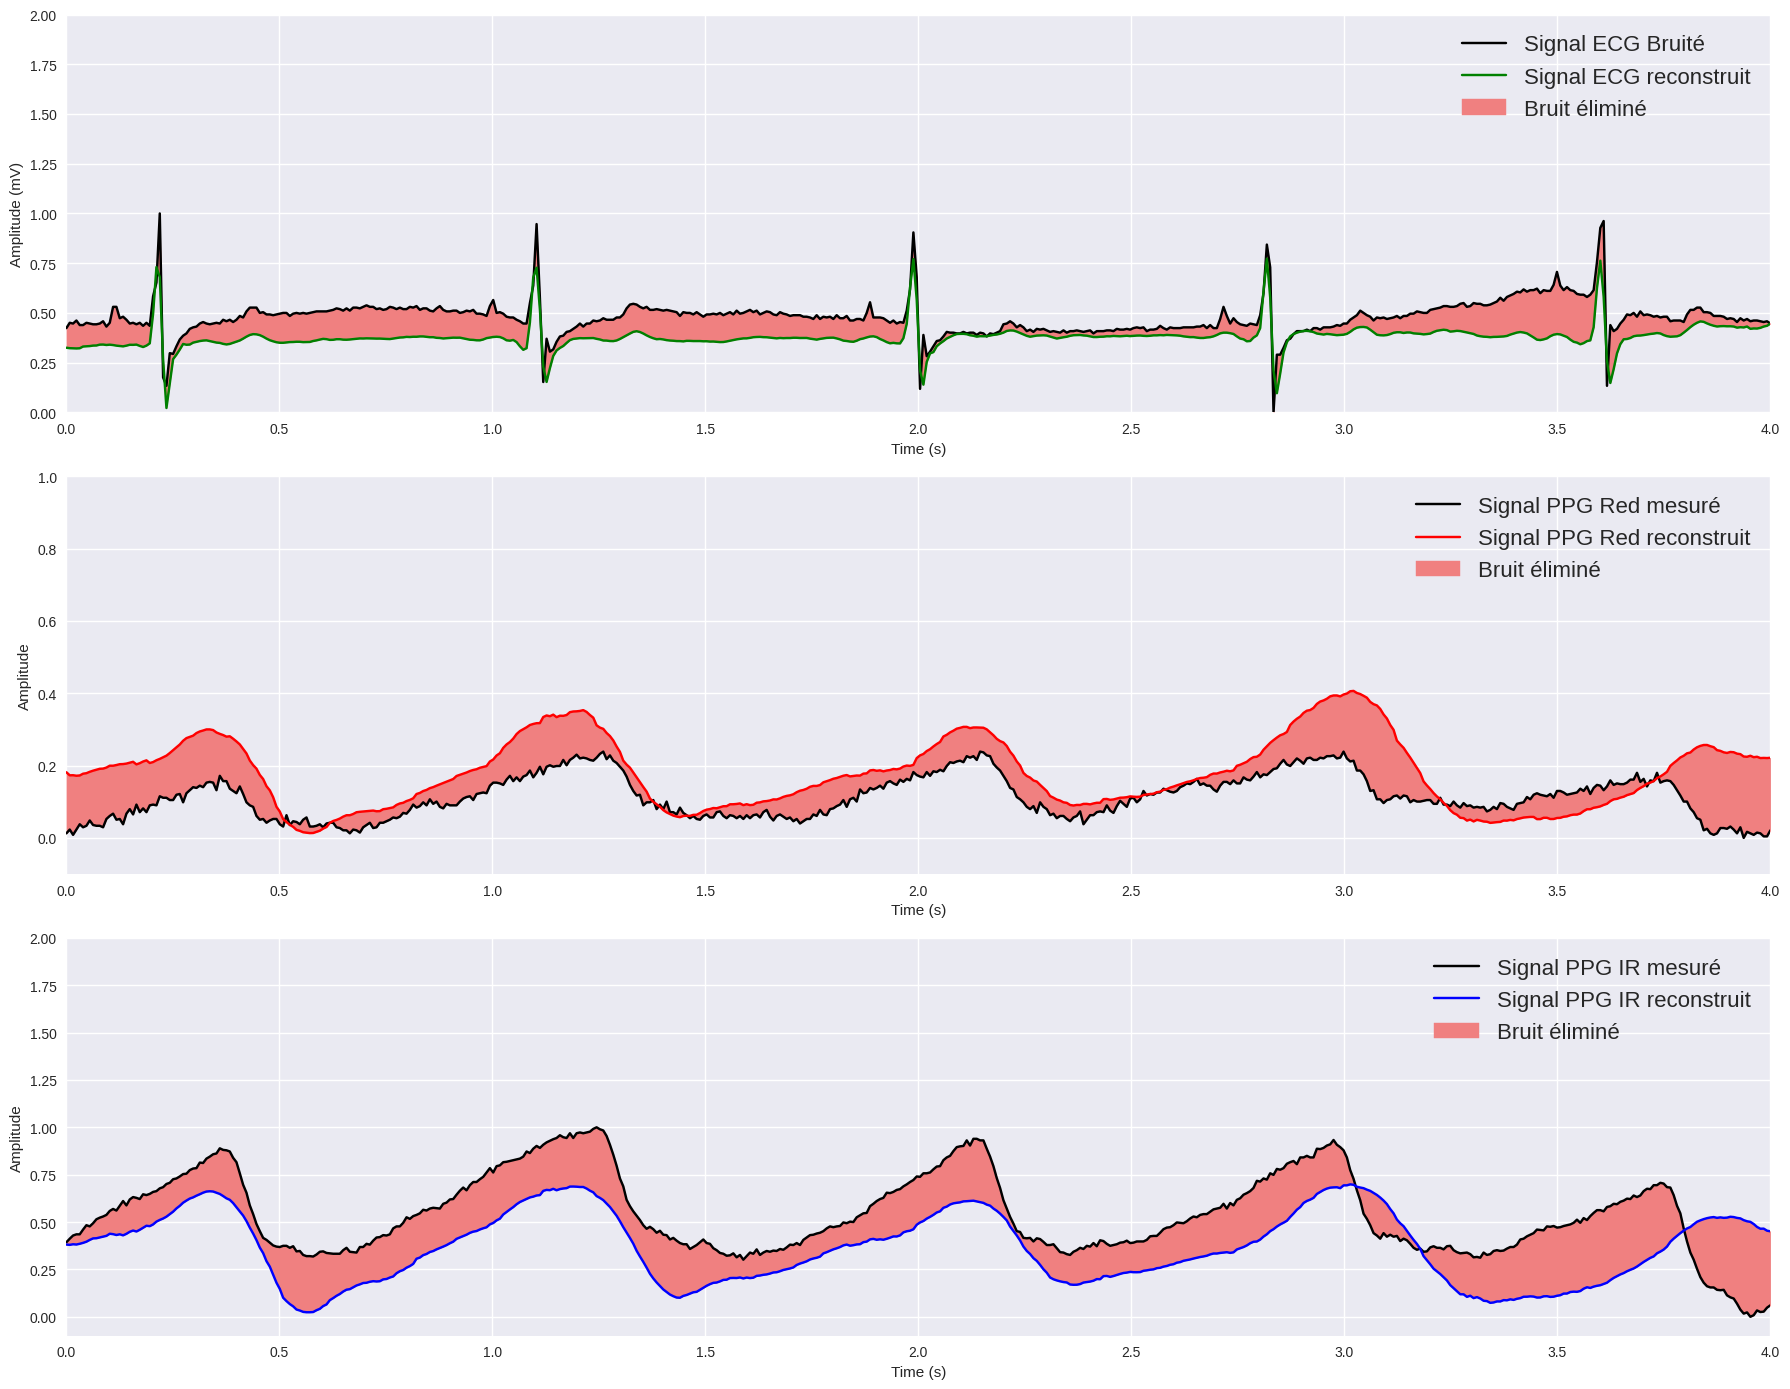

In [ ]:
figure, axis = plt.subplots(nrows=3, ncols=1, figsize=(18, 14))
font = font_manager.FontProperties(size=16)

axis[0].plot(t_p,ecg_arduino,color='black',label="Signal ECG Bruité")
axis[0].plot(t_p,ecg_ppg_signals[0][0],color='green',label='Signal ECG reconstruit')
axis[0].fill_between(t_p,ecg_ppg_signals[0][0],ecg_arduino, color='lightcoral', label='Bruit éliminé')
axis[0].legend(loc='upper right',prop=font)
axis[0].set(xlabel='Time (s)', ylabel='Amplitude (mV)')
axis[0].set_xlim([0, 4])
axis[0].set_ylim([0, 2])

axis[1].plot(t_p,red_arduino,color='black',label='Signal PPG Red mesuré')
axis[1].plot(t_p,ecg_ppg_signals[1][0],color='red',label='Signal PPG Red reconstruit')
axis[1].fill_between(t_p,ecg_ppg_signals[1][0],red_arduino, color='lightcoral', label ='Bruit éliminé')
axis[1].legend(loc='upper right',prop=font)
axis[1].set(xlabel='Time (s)', ylabel='Amplitude')
axis[1].set_xlim([0, 4])
axis[1].set_ylim([-0.1, 1])

font = font_manager.FontProperties(size=16)
axis[2].plot(t_p,ir_arduino,color='black',label='Signal PPG IR mesuré')
axis[2].plot(t_p,ecg_ppg_signals[2][0],color='blue',label='Signal PPG IR reconstruit')
axis[2].fill_between(t_p,ecg_ppg_signals[2][0],ir_arduino, color='lightcoral', label = 'Bruit éliminé')
axis[2].legend(loc='upper right')
axis[2].set(xlabel='Time (s)', ylabel='Amplitude')
axis[2].set_xlim([0, 4])
axis[2].set_ylim([-0.1, 2])


figure.tight_layout()
plt.legend(prop=font)
plt.show()
figure.savefig('data_comparison.tif', format='tif', dpi=300)